In [47]:
import os
import re
import warnings
from pathlib import Path
from collections import Counter
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tomllib
import nltk
from nltk.corpus import stopwords
import pdfplumber
from langdetect import detect, DetectorFactory, LangDetectException
from wordcloud import WordCloud

from config import URBAN_TERMS, URBAN_AUTHORS, URBAN_CONCEPTS

# Настройки
warnings.filterwarnings('ignore')
DetectorFactory.seed = 0
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Константы
ROOT_DIR = Path().resolve().parent
with (ROOT_DIR / "pyproject.toml").open("rb") as config_file:
    pyproject = tomllib.load(config_file)
tool_config = pyproject.get("tool", {}).get("data", {})
DATA_DIR = Path(
    os.getenv(
        "DATA_DIR",
        tool_config.get("data-dir", "data")
    )
)
BOOKS_DIR = DATA_DIR / os.getenv(
    "BOOKS_SUBDIR",
    tool_config.get("books-subdir", "books")
)

# Базовый анализ на количество файлов и размер

In [53]:
def collect_file_metadata(directory, extensions):
    """Сбор метаданных о файлах"""
    metadata = []

    for ext in extensions:
        for file_path in directory.glob(f'**/*{ext}'):
            try:
                file_stat = file_path.stat()
                metadata.append({
                    'file_name': file_path.name,
                    'file_path': str(file_path),
                    'file_size_mb': file_stat.st_size / (1024 * 1024),
                    'file_extension': ext,
                    'last_modified': datetime.fromtimestamp(file_stat.st_mtime),
                    'relative_path': str(file_path.relative_to(DATA_DIR))
                })
            except Exception as e:
                print(f"Ошибка при обработке файла {file_path}: {e}")

    return pd.DataFrame(metadata)


books_metadata = collect_file_metadata(BOOKS_DIR, ['.pdf'])
print(f"Общее количество книг: {len(books_metadata)}")
print(f"Общий объем данных: {books_metadata['file_size_mb'].sum()} MB")
print()
print(books_metadata['file_size_mb'].describe())

Общее количество книг: 9
Общий объем данных: 77.21327209472656 MB

count     9.000000
mean      8.579252
std       5.742194
min       0.718704
25%       4.263350
50%       8.942704
75%      13.608675
max      16.905677
Name: file_size_mb, dtype: float64


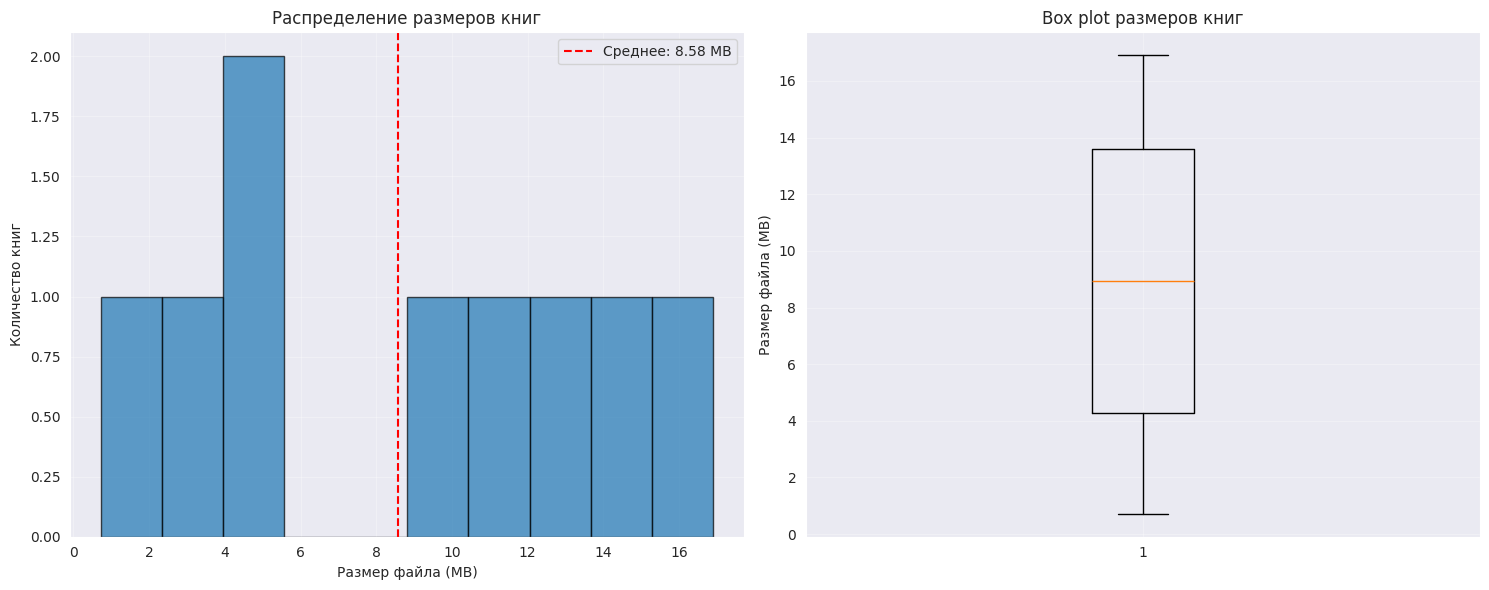

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Гистограмма размеров книг
axes[0].hist(books_metadata['file_size_mb'], bins=10, edgecolor='black', alpha=0.7)
axes[0].axvline(books_metadata['file_size_mb'].mean(), color='red', linestyle='--',
                label=f'Среднее: {books_metadata["file_size_mb"].mean():.2f} MB')
axes[0].set_xlabel('Размер файла (MB)')
axes[0].set_ylabel('Количество книг')
axes[0].set_title('Распределение размеров книг')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot размеров книг
axes[1].boxplot(books_metadata['file_size_mb'])
axes[1].set_ylabel('Размер файла (MB)')
axes[1].set_title('Box plot размеров книг')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('book_sizes_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


In [56]:
print("Топ-5 самых больших книг:")
print(books_metadata.nlargest(5, 'file_size_mb')[['file_name', 'file_size_mb']])

print()

print("Топ-5 самых маленьких книг:")
print(books_metadata.nsmallest(5, 'file_size_mb')[['file_name', 'file_size_mb']])

Топ-5 самых больших книг:
                                           file_name  file_size_mb
2  Лeо_Xоллис_Гоpода_вaм_на_пользу_Гeний_мeгапол...     16.905677
1                     Ольденбург Р. Третье место.pdf     14.182334
0             2006_Charlz_Lendri_Kreativny_gorod.pdf     13.608675
5  Dzhekobs_Smert_i_zhizn_bolshih_amerikanskih_go...     11.148474
6      Transport_v_gorodakh_udobnykh_dlya_zhizni.pdf      8.942704

Топ-5 самых маленьких книг:
                                           file_name  file_size_mb
4         Grigoriy_Revzin_Kak_ustroen_gorod_2019.pdf      0.718704
3                    glaza_ustremlennye_na_ulicu.pdf      2.413424
8  2014_Richard_Florida_Kto_tvoy_gorod_Krativnaya...      4.263350
7                Zukin_Sh_-_Kultury_gorodov_2018.pdf      5.029929
6      Transport_v_gorodakh_udobnykh_dlya_zhizni.pdf      8.942704


# CourseMaterialsAnalyzer: Анализатор учебных материалов

## Идея

Создать специализированный Python-класс для комплексного анализа учебных материалов на предмет урбанистической терминологии, лингвистических характеристик и тематического содержания.

## Метрики качества:
1. **Читаемость текста**: Композитный показатель на основе длины слов и предложений
2. **Лексическое разнообразие**: Отношение уникальных слов к общему количеству
3. **Терминологическая плотность**: Концентрация специальных терминов


## Основные задачи класса:
1. **Извлечение и обработка текста** из PDF-документов
2. **Лингвистический анализ** с расчетом ключевых метрик
3. **Тематическая классификация** по урбанистическим категориям
4. **Идентификация концепций и авторов** в области урбанистики
5. **Количественная оценка** плотности специальной терминологии

## Форматы данных

### Входные данные:
- **PDF-файлы**: Учебные материалы, статьи, книги
- **Конфигурационные словари** (из `config.py`):
  - `URBAN_TERMS`: Термины по категориям
  - `URBAN_AUTHORS`: Авторы и их варианты имен
  - `URBAN_CONCEPTS`: Ключевые концепции и ключевые слова

### Выходные данные:
- **Словари Python** со структурированной информацией
- **Числовые метрики** для статистического анализа
- **Ранжированные списки** терминов и концепций

In [36]:
class CourseMaterialsAnalyzer:
    """
    Анализатор учебных материалов для выявления урбанистической терминологии.

    Класс предоставляет функционал для анализа PDF-документов, извлечения текста,
    расчета лингвистических метрик и идентификации урбанистических концепций.

    Attributes
    ----------
    books_dir : Path
        Директория с PDF-файлами для анализа
    pdf_files : List[Path]
        Список путей к PDF-файлам в директории
    results : List[Dict]
        Результаты анализа для каждого файла
    all_text : str
        Объединенный текст из всех обработанных файлов
    stopwords_set : Set[str]
        Набор стоп-слов для фильтрации текста
    """

    def __init__(self, books_dir: Path) -> None:
        """
        Инициализация анализатора учебных материалов.

        Parameters
        ----------
        books_dir : Path
            Путь к директории с PDF-файлами для анализа
        """
        self.books_dir = books_dir
        self.pdf_files = list(books_dir.glob("*.pdf"))
        self.results = []
        self.all_text = ""
        self.stopwords_set = self._initialize_stopwords()

    def _initialize_stopwords(self) -> set:
        """
        Создание комплексного набора стоп-слов.

        Returns
        -------
        Set[str]
            Набор стоп-слов на русском и английском языках
        """
        stopwords_set = set()
        stopwords_set.update(stopwords.words('russian'))
        stopwords_set.update(stopwords.words('english'))

        # Дополнительные русские стоп-слова
        custom_stopwords = [
            'это', 'вот', 'что', 'как', 'так', 'и', 'а', 'но', 'да', 'нет',
            'или', 'ли', 'же', 'бы', 'б', 'ведь', 'вроде', 'дескать', 'мол',
            'ну', 'же', 'то', 'все', 'всё', 'еще', 'ещё', 'уже', 'тоже',
            'также', 'либо', 'нибудь', 'какой', 'какая', 'какое', 'какие',
            'чей', 'чья', 'чьё', 'чьи', 'сколько', 'который', 'которая',
            'которое', 'которые', 'никто', 'ничто', 'некий', 'некоторый',
            'какой-то', 'кое-какой', 'чей-то', 'некто', 'нечто', 'сам',
            'сама', 'само', 'сами', 'весь', 'вся', 'всё', 'все', 'всю'
        ]

        stopwords_set.update(custom_stopwords)
        return stopwords_set

    def extract_text_from_pdf(self, pdf_path: Path, max_pages: int = 50) -> str:
        """
        Извлечение текстового содержимого из PDF-файла.

        Parameters
        ----------
        pdf_path : Path
            Путь к PDF-файлу
        max_pages : int, optional
            Максимальное количество страниц для обработки (по умолчанию 50)

        Returns
        -------
        str
            Извлеченный текст из документа
        """
        extracted_text = ""

        try:
            with pdfplumber.open(pdf_path) as pdf:
                for page_num, page in enumerate(pdf.pages[:max_pages], 1):
                    page_text = page.extract_text()
                    if page_text:
                        extracted_text += page_text + "\n"

        except Exception as error:
            print(f"Ошибка при чтении файла {pdf_path.name}: {error}")

        return extracted_text

    def analyze_language(self, text: str) -> str:
        """
        Определение языка текста.

        Parameters
        ----------
        text : str
            Текст для анализа языка

        Returns
        -------
        str
            Код языка ('ru', 'en', 'unknown')
        """
        try:
            return detect(text[:5000])
        except LangDetectException:
            return "unknown"

    def calculate_nlp_metrics(self, text: str) -> dict:
        """
        Расчет лингвистических метрик текста.

        Parameters
        ----------
        text : str
            Текст для анализа

        Returns
        -------
        Dict[str, float]
            Словарь с рассчитанными метриками:
            - total_chars: общее количество символов
            - total_words: общее количество слов
            - avg_word_length: средняя длина слова
            - special_chars_ratio: доля специальных символов
            - readability_score: оценка читаемости
            - lexical_diversity: лексическое разнообразие
            - avg_sentence_length: средняя длина предложения
        """
        if not text.strip():
            return self._get_empty_metrics()

        # Базовые метрики
        total_chars = len(text)
        words = re.findall(r'\b\w+\b', text.lower())
        total_words = len(words)

        # Расчет производных метрик
        metrics = {
            'total_chars': total_chars,
            'total_words': total_words,
            'avg_word_length': self._calculate_avg_word_length(words, total_words),
            'special_chars_ratio': self._calculate_special_chars_ratio(text, total_chars),
            'readability_score': 0,
            'lexical_diversity': 0,
            'avg_sentence_length': 0
        }

        sentences = re.split(r'[.!?]+', text)
        num_sentences = len([s for s in sentences if s.strip()])
        metrics['avg_sentence_length'] = total_words / num_sentences
        metrics['readability_score'] = self._calculate_readability_score(
            metrics['avg_word_length'],
            metrics['avg_sentence_length']
        )
        metrics['lexical_diversity'] = len(set(words)) / total_words

        return metrics

    def _get_empty_metrics(self) -> dict:
        """Возвращает метрики по умолчанию для пустого текста."""
        return {
            'total_chars': 0,
            'total_words': 0,
            'avg_word_length': 0,
            'special_chars_ratio': 0,
            'readability_score': 0,
            'lexical_diversity': 0,
            'avg_sentence_length': 0
        }

    def _calculate_avg_word_length(self, words: list, total_words: int) -> float:
        """Расчет средней длины слова."""
        if total_words == 0:
            return 0.0
        return sum(len(word) for word in words) / total_words

    def _calculate_special_chars_ratio(self, text: str, total_chars: int) -> float:
        """Расчет доли специальных символов."""
        if total_chars == 0:
            return 0.0
        special_chars = len(re.findall(r'[^\w\s]', text))
        return special_chars / total_chars

    def _calculate_readability_score(self, avg_word_length: float,
                                     avg_sentence_length: float) -> float:
        """Расчет показателя читаемости."""
        return (avg_word_length * 0.5) + (avg_sentence_length * 0.3)

    def extract_topic_keywords(self, text: str, top_n: int = 20) -> dict:
        """
        Извлечение ключевых слов из текста с помощью частотного анализа.

        Parameters
        ----------
        text : str
            Текст для анализа
        top_n : int, optional
            Количество возвращаемых ключевых слов (по умолчанию 20)

        Returns
        -------
        Dict[str, int]
            Словарь ключевых слов с частотами встречаемости
        """
        if not text.strip():
            return {}

        # Очистка и токенизация текста
        cleaned_text = self._clean_text_for_keywords(text)
        words = cleaned_text.split()

        # Фильтрация слов
        filtered_words = [
            word for word in words
            if (word not in self.stopwords_set and
                len(word) > 3 and
                not word.isspace())
        ]

        # Подсчет частот
        word_freq = Counter(filtered_words)
        return dict(word_freq.most_common(top_n))

    def _clean_text_for_keywords(self, text: str) -> str:
        """Очистка текста для извлечения ключевых слов."""
        text_lower = text.lower()
        text_clean = re.sub(r'[^\w\s]', ' ', text_lower)
        text_clean = re.sub(r'\d+', ' ', text_clean)
        return text_clean

    def identify_urban_concepts_extended(self, text: str) -> dict:
        """
        Идентификация урбанистических концепций в тексте.

        Parameters
        ----------
        text : str
            Текст для анализа

        Returns
        -------
        Dict[str, int]
            Словарь найденных концепций с количеством упоминаний
        """
        concepts_found = {}
        text_lower = text.lower()

        for concept, keywords in URBAN_CONCEPTS.items():
            total_count = 0
            for keyword in keywords:
                keyword_lower = keyword.lower()
                total_count += len(re.findall(re.escape(keyword_lower), text_lower))

            if total_count > 0:
                concepts_found[concept] = total_count

        return concepts_found

    def count_urban_terms_by_category(self, text: str) -> dict:
        """
        Категоризированный подсчет урбанистических терминов.

        Parameters
        ----------
        text : str
            Текст для анализа

        Returns
        -------
        Dict[str, Dict]
            Иерархический словарь с категориями терминов и их частотами
        """
        categories_found = {}
        text_lower = text.lower()

        for category, terms in URBAN_TERMS.items():
            category_data = self._count_terms_in_category(text_lower, category, terms)
            if category_data:
                categories_found[category] = category_data

        return categories_found

    def _count_terms_in_category(self, text_lower: str,
                                 category: str, terms: list) -> dict:
        """Подсчет терминов в конкретной категории."""
        category_total = 0
        category_terms = {}

        for term in terms:
            term_lower = term.lower()
            count = len(re.findall(re.escape(term_lower), text_lower))

            if count > 0:
                category_total += count
                category_terms[term] = count

        if category_total > 0:
            return {
                'total': category_total,
                'terms': category_terms
            }
        return None

    def count_authors_by_category(self, text: str) -> dict:
        """
        Категоризированный подсчет упоминаний авторов.

        Parameters
        ----------
        text : str
            Текст для анализа

        Returns
        -------
        Dict[str, Dict]
            Иерархический словарь с категориями авторов и частотами упоминаний
        """
        authors_found = {}
        text_lower = text.lower()

        for category, authors_dict in URBAN_AUTHORS.items():
            category_data = self._count_authors_in_category(text_lower, category, authors_dict)
            if category_data:
                authors_found[category] = category_data

        return authors_found

    def _count_authors_in_category(self, text_lower: str,
                                   category: str, authors_dict: dict) -> dict:
        """Подсчет авторов в конкретной категории."""
        category_total = 0
        category_authors = {}

        for author_name, author_variants in authors_dict.items():
            author_count = 0
            for variant in author_variants:
                variant_lower = variant.lower()
                author_count += len(re.findall(re.escape(variant_lower), text_lower))

            if author_count > 0:
                category_total += author_count
                category_authors[author_name] = author_count

        if category_total > 0:
            return {
                'total': category_total,
                'authors': category_authors
            }
        return None

    def analyze_urban_density(self, text: str) -> dict:
        """
        Анализ плотности урбанистической терминологии в тексте.

        Parameters
        ----------
        text : str
            Текст для анализа

        Returns
        -------
        Dict[str, Any]
            Словарь с метриками плотности терминологии:
            - density: плотность урбанистических терминов
            - total_urban_terms: общее количество урбанистических терминов
            - total_words: общее количество слов в тексте
            - top_terms: топ-10 наиболее частых терминов
        """
        if not text.strip():
            return {
                'density': 0,
                'total_urban_terms': 0,
                'total_words': 0,
                'top_terms': []
            }

        text_lower = text.lower()
        total_words = len(re.findall(r'\b\w+\b', text_lower))

        # Подсчет всех урбанистических терминов
        urban_terms_data = self._collect_all_urban_terms(text_lower)
        total_urban_terms = urban_terms_data['total']
        all_terms = urban_terms_data['terms']

        # Расчет плотности
        urban_density = total_urban_terms / total_words if total_words > 0 else 0

        # Топ-10 терминов
        top_terms = sorted(all_terms, key=lambda x: x[1], reverse=True)[:10]

        return {
            'density': urban_density,
            'total_urban_terms': total_urban_terms,
            'total_words': total_words,
            'top_terms': top_terms
        }

    def _collect_all_urban_terms(self, text_lower: str) -> dict:
        """Сбор всех урбанистических терминов из текста."""
        total_count = 0
        terms_list = []

        for category, terms in URBAN_TERMS.items():
            for term in terms:
                term_lower = term.lower()
                count = len(re.findall(re.escape(term_lower), text_lower))

                if count > 0:
                    total_count += count
                    terms_list.append((term, count))

        return {'total': total_count, 'terms': terms_list}

# Метрики лингвистического анализа
## Идея

Оценка материалов по:
1. **Лингвистические характеристики** - сложность и структура текста
2. **Тематическая направленность** - ключевые концепции и термины, соответствие урбанистической тематике

## Основные метрики и их значение

### 1. **Лингвистические метрики**

#### Читаемость текста (`readability_score`)
- **Что измеряет**: Сложность восприятия текста
- **Как рассчитывается**: Комбинация средней длины слов (50%) и средней длины предложений (30%)
- **Интерпретация**:
  - 0-2: Очень простой текст
  - 3-5: Средняя сложность
  - 6+: Сложный академический текст
- **Зачем нужно**: Помогает оценить доступность материала для целевой аудитории

#### 🎨 Лексическое разнообразие (`lexical_diversity`)
- **Что измеряет**: Богатство словарного запаса
- **Как рассчитывается**: Отношение уникальных слов к общему количеству слов
- **Интерпретация**:
  - 0-0.3: Низкое разнообразие (много повторений)
  - 0.4-0.6: Среднее разнообразие
  - 0.7+: Высокое разнообразие (богатый словарный запас)
- **Зачем нужно**: Показывает глубину проработки темы и стиль автора

#### 📏 Средняя длина предложения (`avg_sentence_length`)
- **Что измеряет**: Стилистические особенности текста
- **Интерпретация**:
  - 5-10 слов: Простой, журналистский стиль
  - 11-20 слов: Стандартный академический стиль
  - 21+ слов: Сложный научный стиль
- **Зачем нужно**: Характеризует сложность синтаксиса

### 2. **Тематические метрики**

#### 🏙️ Плотность урбанистических терминов (`urban_density`)
- **Что измеряет**: Концентрация специальной терминологии
- **Как рассчитывается**: `(Количество урбанистических терминов / Общее количество слов) × 100%`
- **Интерпретация**:
  - <1%: Общий текст, слабая специализация
  - 1-3%: Умеренная специализация
  - 3-5%: Высокая специализация
  - больше 5%: Глубоко специализированный текст
- **Зачем нужно**: Оценивает степень специализации материала

#### 🔑 Ключевые слова (`keywords`)
- **Что измеряет**: Основные темы документа
- **Как выделяется**:
  1. Удаление стоп-слов
  2. Фильтрация коротких слов (<3 символов)
  3. Частотный анализ
- **Зачем нужно**: Быстрое определение тематического фокуса документа

In [43]:
analyzer = CourseMaterialsAnalyzer(BOOKS_DIR)

# Глобальные счетчики для сводной статистики
global_stats = {
    'total_urban_terms': 0,
    'total_authors_mentions': 0,
    'total_documents': 0,
    'languages': Counter(),
    'processed_files': []
}


def print_document_header(file_number: int, total_files: int, file_name: str) -> None:
    """Вывод заголовка для текущего анализируемого документа."""
    print(f"\n{'=' * 60}")
    print(f"📖 ДОКУМЕНТ {file_number}/{total_files}: {file_name}")
    print(f"{'=' * 60}")


def print_linguistic_metrics(language: str, metrics: dict) -> None:
    """Вывод лингвистических метрик документа."""
    print(f"ЛИНГВИСТИЧЕСКИЙ АНАЛИЗ:")
    print(
        f"  ├── Язык документа: {'Русский' if language == 'ru' else 'Английский' if language == 'en' else 'Неизвестный'}")
    print(f"  ├── Объем текста: {metrics['total_words']:,} слов, {metrics['total_chars']:,} символов")
    print(f"  ├── Читаемость текста: {metrics['readability_score']:.2f}")
    print(f"  ├── Лексическое разнообразие: {metrics['lexical_diversity']:.2%}")
    print(f"  └── Средняя длина предложения: {metrics['avg_sentence_length']:.1f} слов")


def print_topic_analysis(keywords: dict, concepts: dict) -> None:
    """Вывод результатов тематического анализа."""
    if keywords:
        top_keywords = list(keywords.items())[:5]
        keywords_str = ', '.join([f'"{k}" ({v})' for k, v in top_keywords])
        print(f"КЛЮЧЕВЫЕ СЛОВА:")
        print(f"  └── Топ-5: {keywords_str}")

    if concepts:
        top_concepts = sorted(concepts.items(), key=lambda x: x[1], reverse=True)[:3]
        concepts_str = ', '.join([f'{k.replace("_", " ").title()} ({v})' for k, v in top_concepts])
        print(f"УРБАНИСТИЧЕСКИЕ КОНЦЕПЦИИ:")
        print(f"  └── Основные: {concepts_str}")


def print_urban_terminology(categories: dict, density_data: dict) -> None:
    """Вывод анализа урбанистической терминологии."""
    print(f"УРБАНИСТИЧЕСКАЯ ТЕРМИНОЛОГИЯ:")
    if not categories:
        print(f"  └── Термины не обнаружены")
        return

    total_terms = sum(cat_data['total'] for cat_data in categories.values())
    density = density_data['density']

    print(f"  ├── Общее количество терминов: {total_terms:,}")
    print(f"  ├── Плотность терминов: {density:.2%}")
    print(f"  └── Топ-3 категории:")

    # Сортировка категорий по количеству терминов
    sorted_categories = sorted(
        categories.items(),
        key=lambda x: x[1]['total'],
        reverse=True
    )[:3]

    for idx, (category, cat_data) in enumerate(sorted_categories, 1):
        top_terms = sorted(
            cat_data['terms'].items(),
            key=lambda x: x[1],
            reverse=True
        )[:3]
        terms_str = ', '.join([f'"{k}" ({v})' for k, v in top_terms])

        print(f"     {idx}. {category.title()}: {cat_data['total']:,} терминов")
        print(f"        Наиболее частые: {terms_str}")

    return total_terms


def print_authors_analysis(authors_data: dict) -> None:
    """Вывод анализа упоминаний авторов."""
    print(f"УПОМИНАНИЯ АВТОРОВ:")
    if not authors_data:
        print(f"  └── Упоминания не обнаружены")
        return 0

    total_mentions = sum(cat_data['total'] for cat_data in authors_data.values())

    print(f"  ├── Всего упоминаний: {total_mentions:,}")
    print(f"  └── Топ-2 категории:")

    # Сортировка категорий по количеству упоминаний
    sorted_categories = sorted(
        authors_data.items(),
        key=lambda x: x[1]['total'],
        reverse=True
    )[:2]

    for idx, (category, cat_data) in enumerate(sorted_categories, 1):
        # Получение топ-авторов категории
        top_authors = sorted(
            cat_data['authors'].items(),
            key=lambda x: x[1],
            reverse=True
        )[:2]
        authors_str = ', '.join([f'{k} ({v})' for k, v in top_authors])

        print(f"     {idx}. {category.title()}: {cat_data['total']:,} упоминаний")
        print(f"        Основные авторы: {authors_str}")

    return total_mentions


# Проход по всем книгам
for file_idx, pdf_file in enumerate(analyzer.pdf_files, 1):
    print_document_header(file_idx, len(analyzer.pdf_files), pdf_file.name)

    try:
        text = analyzer.extract_text_from_pdf(pdf_file)
        if not text.strip():
            print(f"Файл пуст или не содержит текста")
            continue
        analyzer.all_text += text + "\n"

        # Определение языка документа
        language = analyzer.analyze_language(text)
        global_stats['languages'][language] += 1

        # Расчет лингвистических метрик
        nlp_metrics = analyzer.calculate_nlp_metrics(text)
        print_linguistic_metrics(language, nlp_metrics)

        # Тематический анализ
        keywords = analyzer.extract_topic_keywords(text, top_n=20)
        urban_concepts = analyzer.identify_urban_concepts_extended(text)
        print_topic_analysis(keywords, urban_concepts)

        # Анализ урбанистической терминологии
        urban_categories = analyzer.count_urban_terms_by_category(text)
        urban_density = analyzer.analyze_urban_density(text)
        total_terms = print_urban_terminology(urban_categories, urban_density)

        if total_terms:
            global_stats['total_urban_terms'] += total_terms

        # Анализ упоминаний авторов
        authors_categories = analyzer.count_authors_by_category(text)
        total_authors = print_authors_analysis(authors_categories)

        if total_authors:
            global_stats['total_authors_mentions'] += total_authors

        # Сохранение детальных результатов
        document_result = {
            'file_name': pdf_file.name,
            'file_size_mb': round(pdf_file.stat().st_size / (1024 * 1024), 2),
            'language': language,
            'text_length_chars': nlp_metrics['total_chars'],
            'text_length_words': nlp_metrics['total_words'],
            'avg_word_length': round(nlp_metrics['avg_word_length'], 2),
            'special_chars_ratio': round(nlp_metrics['special_chars_ratio'], 4),
            'readability_score': round(nlp_metrics['readability_score'], 2),
            'lexical_diversity': round(nlp_metrics['lexical_diversity'], 4),
            'avg_sentence_length': round(nlp_metrics['avg_sentence_length'], 1),
            'keywords_count': len(keywords),
            'top_keywords': dict(list(keywords.items())[:10]),
            'urban_concepts_count': len(urban_concepts),
            'urban_concepts': urban_concepts,
            'urban_categories_count': len(urban_categories) if urban_categories else 0,
            'urban_categories': urban_categories,
            'authors_categories_count': len(authors_categories) if authors_categories else 0,
            'authors_categories': authors_categories,
            'urban_density': round(urban_density['density'], 4),
            'urban_terms_total': urban_density['total_urban_terms'],
            'authors_mentions_total': total_authors
        }

        analyzer.results.append(document_result)
        global_stats['processed_files'].append(pdf_file.name)
        global_stats['total_documents'] += 1

    except Exception as error:
        print(f"\nОшибка при анализе файла {pdf_file.name}: {error}")
        continue

if analyzer.results:
    books_df = pd.DataFrame(analyzer.results)


📖 ДОКУМЕНТ 1/9: 2006_Charlz_Lendri_Kreativny_gorod.pdf
ЛИНГВИСТИЧЕСКИЙ АНАЛИЗ:
  ├── Язык документа: Русский
  ├── Объем текста: 11,180 слов, 81,793 символов
  ├── Читаемость текста: 8.78
  ├── Лексическое разнообразие: 44.44%
  └── Средняя длина предложения: 19.2 слов
КЛЮЧЕВЫЕ СЛОВА:
  └── Топ-5: "города" (96), "город" (68), "городов" (41), "новые" (35), "развития" (35)
УРБАНИСТИЧЕСКИЕ КОНЦЕПЦИИ:
  └── Основные: Экологический Подход (2)
УРБАНИСТИЧЕСКАЯ ТЕРМИНОЛОГИЯ:
  ├── Общее количество терминов: 475
  ├── Плотность терминов: 4.25%
  └── Топ-3 категории:
     1. Основные: 336 терминов
        Наиболее частые: "город" (332), "мегаполис" (2), "урбанизм" (1)
     2. Жилье: 26 терминов
        Наиболее частые: "дом" (25), "жилищный фонд" (1)
     3. Инфраструктура: 25 терминов
        Наиболее частые: "мост" (15), "транспорт" (4), "коммуникации" (2)
УПОМИНАНИЯ АВТОРОВ:
  ├── Всего упоминаний: 5
  └── Топ-2 категории:
     1. Архитекторы: 4 упоминаний
        Основные авторы: Людвиг Мис

In [42]:
books_df

,file_name,file_size_mb,language,text_length_chars,text_length_words,avg_word_length,special_chars_ratio,readability_score,lexical_diversity,avg_sentence_length,...,top_keywords,urban_concepts_count,urban_concepts,urban_categories_count,urban_categories,authors_categories_count,authors_categories,urban_density,urban_terms_total,authors_mentions_total
0,2006_Charlz_Lendri_Kreativny_gorod.pdf,13.61,ru,81793,11180,6.05,0.0361,8.78,0.4444,19.2,...,"{'города': 96, 'город': 68, 'городов': 41, 'но...",1,{'экологический подход': 2},11,"{'основные': {'total': 336, 'terms': {'город':...",2,"{'классики': {'total': 1, 'authors': {'Джейн Д...",0.0425,475,5
1,Ольденбург Р. Третье место.pdf,14.18,ru,79319,11258,5.69,0.0510,7.99,0.4174,17.2,...,"{'жизни': 66, 'места': 65, 'люди': 47, 'мест':...",0,{},10,"{'основные': {'total': 103, 'terms': {'город':...",4,"{'классики': {'total': 5, 'authors': {'Джейн Д...",0.0210,236,12
2,Лeо_Xоллис_Гоpода_вaм_на_пользу_Гeний_мeгапол...,16.91,ru,75158,10957,5.59,0.0381,8.77,0.4592,19.9,...,"{'город': 109, 'города': 73, 'жизни': 29, 'гла...",1,{'исторический урбанизм': 1},11,"{'основные': {'total': 321, 'terms': {'город':...",2,"{'классики': {'total': 6, 'authors': {'Джейн Д...",0.0420,460,17
3,glaza_ustremlennye_na_ulicu.pdf,2.41,ru,93262,14531,5.10,0.0502,6.44,0.4140,13.0,...,"{'джейн': 184, 'жизни': 49, 'джекобс': 43, 'жи...",0,{},8,"{'основные': {'total': 73, 'terms': {'город': ...",2,"{'классики': {'total': 51, 'authors': {'Джейн ...",0.0120,175,69
4,Grigoriy_Revzin_Kak_ustroen_gorod_2019.pdf,0.72,ru,150162,21399,5.73,0.0383,7.26,0.3773,14.6,...,"{'город': 155, 'города': 103, 'устроен': 55, '...",3,"{'культурные исследования': 1, 'экологический ...",11,"{'основные': {'total': 396, 'terms': {'город':...",3,"{'классики': {'total': 23, 'authors': {'Джейн ...",0.0329,705,98
5,Dzhekobs_Smert_i_zhizn_bolshih_amerikanskih_go...,11.15,ru,105677,15777,5.44,0.0374,8.68,0.3989,19.9,...,"{'города': 79, 'городов': 55, 'больших': 45, '...",0,{},10,"{'основные': {'total': 338, 'terms': {'город':...",3,"{'классики': {'total': 37, 'authors': {'Джейн ...",0.0357,564,45
6,Transport_v_gorodakh_udobnykh_dlya_zhizni.pdf,8.94,ru,131841,17150,6.46,0.0305,8.45,0.3608,17.4,...,"{'городах': 117, 'транспорта': 107, 'города': ...",1,{'экологический подход': 3},11,"{'основные': {'total': 487, 'terms': {'город':...",3,"{'классики': {'total': 5, 'authors': {'Илья Ил...",0.0706,1210,12
7,Zukin_Sh_-_Kultury_gorodov_2018.pdf,5.03,ru,139804,18520,6.30,0.0331,8.71,0.4104,18.5,...,"{'культуры': 103, 'городов': 74, 'города': 72,...",1,{'социальная география': 1},11,"{'основные': {'total': 313, 'terms': {'город':...",3,"{'классики': {'total': 1, 'authors': {'Льюис М...",0.0450,834,11
8,2014_Richard_Florida_Kto_tvoy_gorod_Krativnaya...,4.26,ru,71834,10359,5.67,0.0384,7.61,0.4273,15.9,...,"{'место': 53, 'места': 42, 'людей': 29, 'часть...",0,{},11,"{'основные': {'total': 92, 'terms': {'город': ...",3,"{'классики': {'total': 1, 'authors': {'Джейн Д...",0.0200,207,17


In [45]:
print("СТАТИСТИКА МАТЕРИАЛОВ КУРСА:")
print(f"Всего книг: {len(books_df)}")
print(f"Общее количество слов: {books_df['text_length_words'].sum():,}")
print(f"Средняя длина книги: {books_df['text_length_words'].mean():,.0f} слов")
print(f"Медианная длина: {books_df['text_length_words'].median():,.0f} слов")
print(f"Средняя плотность урбанистических терминов: {books_df['urban_density'].mean():.2%}")
print(f"Средняя оценка читаемости: {books_df['readability_score'].mean():.2f}")
print(f"Среднее лексическое разнообразие: {books_df['lexical_diversity'].mean():.2%}")

if 'language' in books_df.columns:
    lang_counts = books_df['language'].value_counts()
    print(f"\nРАСПРЕДЕЛЕНИЕ ЯЗЫКОВ:")
    for lang, count in lang_counts.items():
        percentage = (count / len(books_df)) * 100
        print(f"  {lang}: {count} книг ({percentage:.1f}%)")

print(f"\nРАСПРЕДЕЛЕНИЕ УРБАНИСТИЧЕСКИХ ТЕРМИНОВ ПО КАТЕГОРИЯМ:")
all_categories = {}
for _, row in books_df.iterrows():
    if isinstance(row['urban_categories'], dict):
        for category, cat_data in row['urban_categories'].items():
            if category not in all_categories:
                all_categories[category] = 0
            all_categories[category] += cat_data['total']
if all_categories:
    sorted_categories = sorted(all_categories.items(), key=lambda x: x[1], reverse=True)
    for category, count in sorted_categories[:5]:  # Топ-5 категорий
        percentage = (count / sum(all_categories.values())) * 100
        print(f"  {category}: {count:,} терминов ({percentage:.1f}%)")

print(f"\nРАСПРЕДЕЛЕНИЕ АВТОРОВ ПО КАТЕГОРИЯМ:")
all_authors = {}
all_author_categories = {}
for _, row in books_df.iterrows():
    if isinstance(row['authors_categories'], dict):
        for category, cat_data in row['authors_categories'].items():
            if category not in all_author_categories:
                all_author_categories[category] = 0
            all_author_categories[category] += cat_data['total']

            # Собираем отдельных авторов
            for author, count in cat_data['authors'].items():
                if author not in all_authors:
                    all_authors[author] = 0
                all_authors[author] += count
if all_author_categories:
    sorted_categories = sorted(all_author_categories.items(), key=lambda x: x[1], reverse=True)
    for category, count in sorted_categories[:3]:  # Топ-3 категории
        percentage = (count / sum(all_author_categories.values())) * 100
        print(f"  {category}: {count:,} упоминаний ({percentage:.1f}%)")

if all_authors:
    print(f"\nСАМЫЕ ЧАСТО УПОМИНАЕМЫЕ АВТОРЫ:")
    sorted_authors = sorted(all_authors.items(), key=lambda x: x[1], reverse=True)
    for author, freq in sorted_authors[:5]:
        print(f"  {author}: {freq} упоминаний")

all_concepts = {}
for _, row in books_df.iterrows():
    if isinstance(row['urban_concepts'], dict):
        for concept, count in row['urban_concepts'].items():
            if concept not in all_concepts:
                all_concepts[concept] = 0
            all_concepts[concept] += count
if all_concepts:
    print(f"\nСАМЫЕ ЧАСТЫЕ УРБАНИСТИЧЕСКИЕ КОНЦЕПЦИИ:")
    sorted_concepts = sorted(all_concepts.items(), key=lambda x: x[1], reverse=True)
    for concept, freq in sorted_concepts[:5]:
        print(f"  {concept.replace('_', ' ')}: {freq} упоминаний")

СТАТИСТИКА МАТЕРИАЛОВ КУРСА:
Всего книг: 9
Общее количество слов: 131,131
Средняя длина книги: 14,570 слов
Медианная длина: 14,531 слов
Средняя плотность урбанистических терминов: 3.57%
Средняя оценка читаемости: 8.08
Среднее лексическое разнообразие: 41.22%

РАСПРЕДЕЛЕНИЕ ЯЗЫКОВ:
  ru: 9 книг (100.0%)

РАСПРЕДЕЛЕНИЕ УРБАНИСТИЧЕСКИХ ТЕРМИНОВ ПО КАТЕГОРИЯМ:
  основные: 2,459 терминов (50.5%)
  инфраструктура: 750 терминов (15.4%)
  жилье: 484 терминов (9.9%)
  экология: 356 терминов (7.3%)
  экономика: 171 терминов (3.5%)

РАСПРЕДЕЛЕНИЕ АВТОРОВ ПО КАТЕГОРИЯМ:
  классики: 130 упоминаний (45.5%)
  архитекторы: 75 упоминаний (26.2%)
  российские: 67 упоминаний (23.4%)

САМЫЕ ЧАСТО УПОМИНАЕМЫЕ АВТОРЫ:
  Джейн Джекобс: 63 упоминаний
  Людвиг Мис ван дер Роэ: 58 упоминаний
  Григорий Ревзин: 55 упоминаний
  Ле Корбюзье: 40 упоминаний
  Льюис Мамфорд: 12 упоминаний

САМЫЕ ЧАСТЫЕ УРБАНИСТИЧЕСКИЕ КОНЦЕПЦИИ:
  экологический подход: 6 упоминаний
  исторический урбанизм: 1 упоминаний
  культурные и

# Выводы анализа учебных материалов по урбанистике

1. **Высокая терминологическая плотность**: Все документы содержат значительное количество специализированной лексики
2. **Академическая глубина**: Средняя читаемость 8.08 соответствует уровню магистратуры
3. **Широкий охват тем**: Основные аспекты урбанистики хорошо представлены
4. **Репрезентативный авторский состав**: Включены ключевые фигуры дисциплины


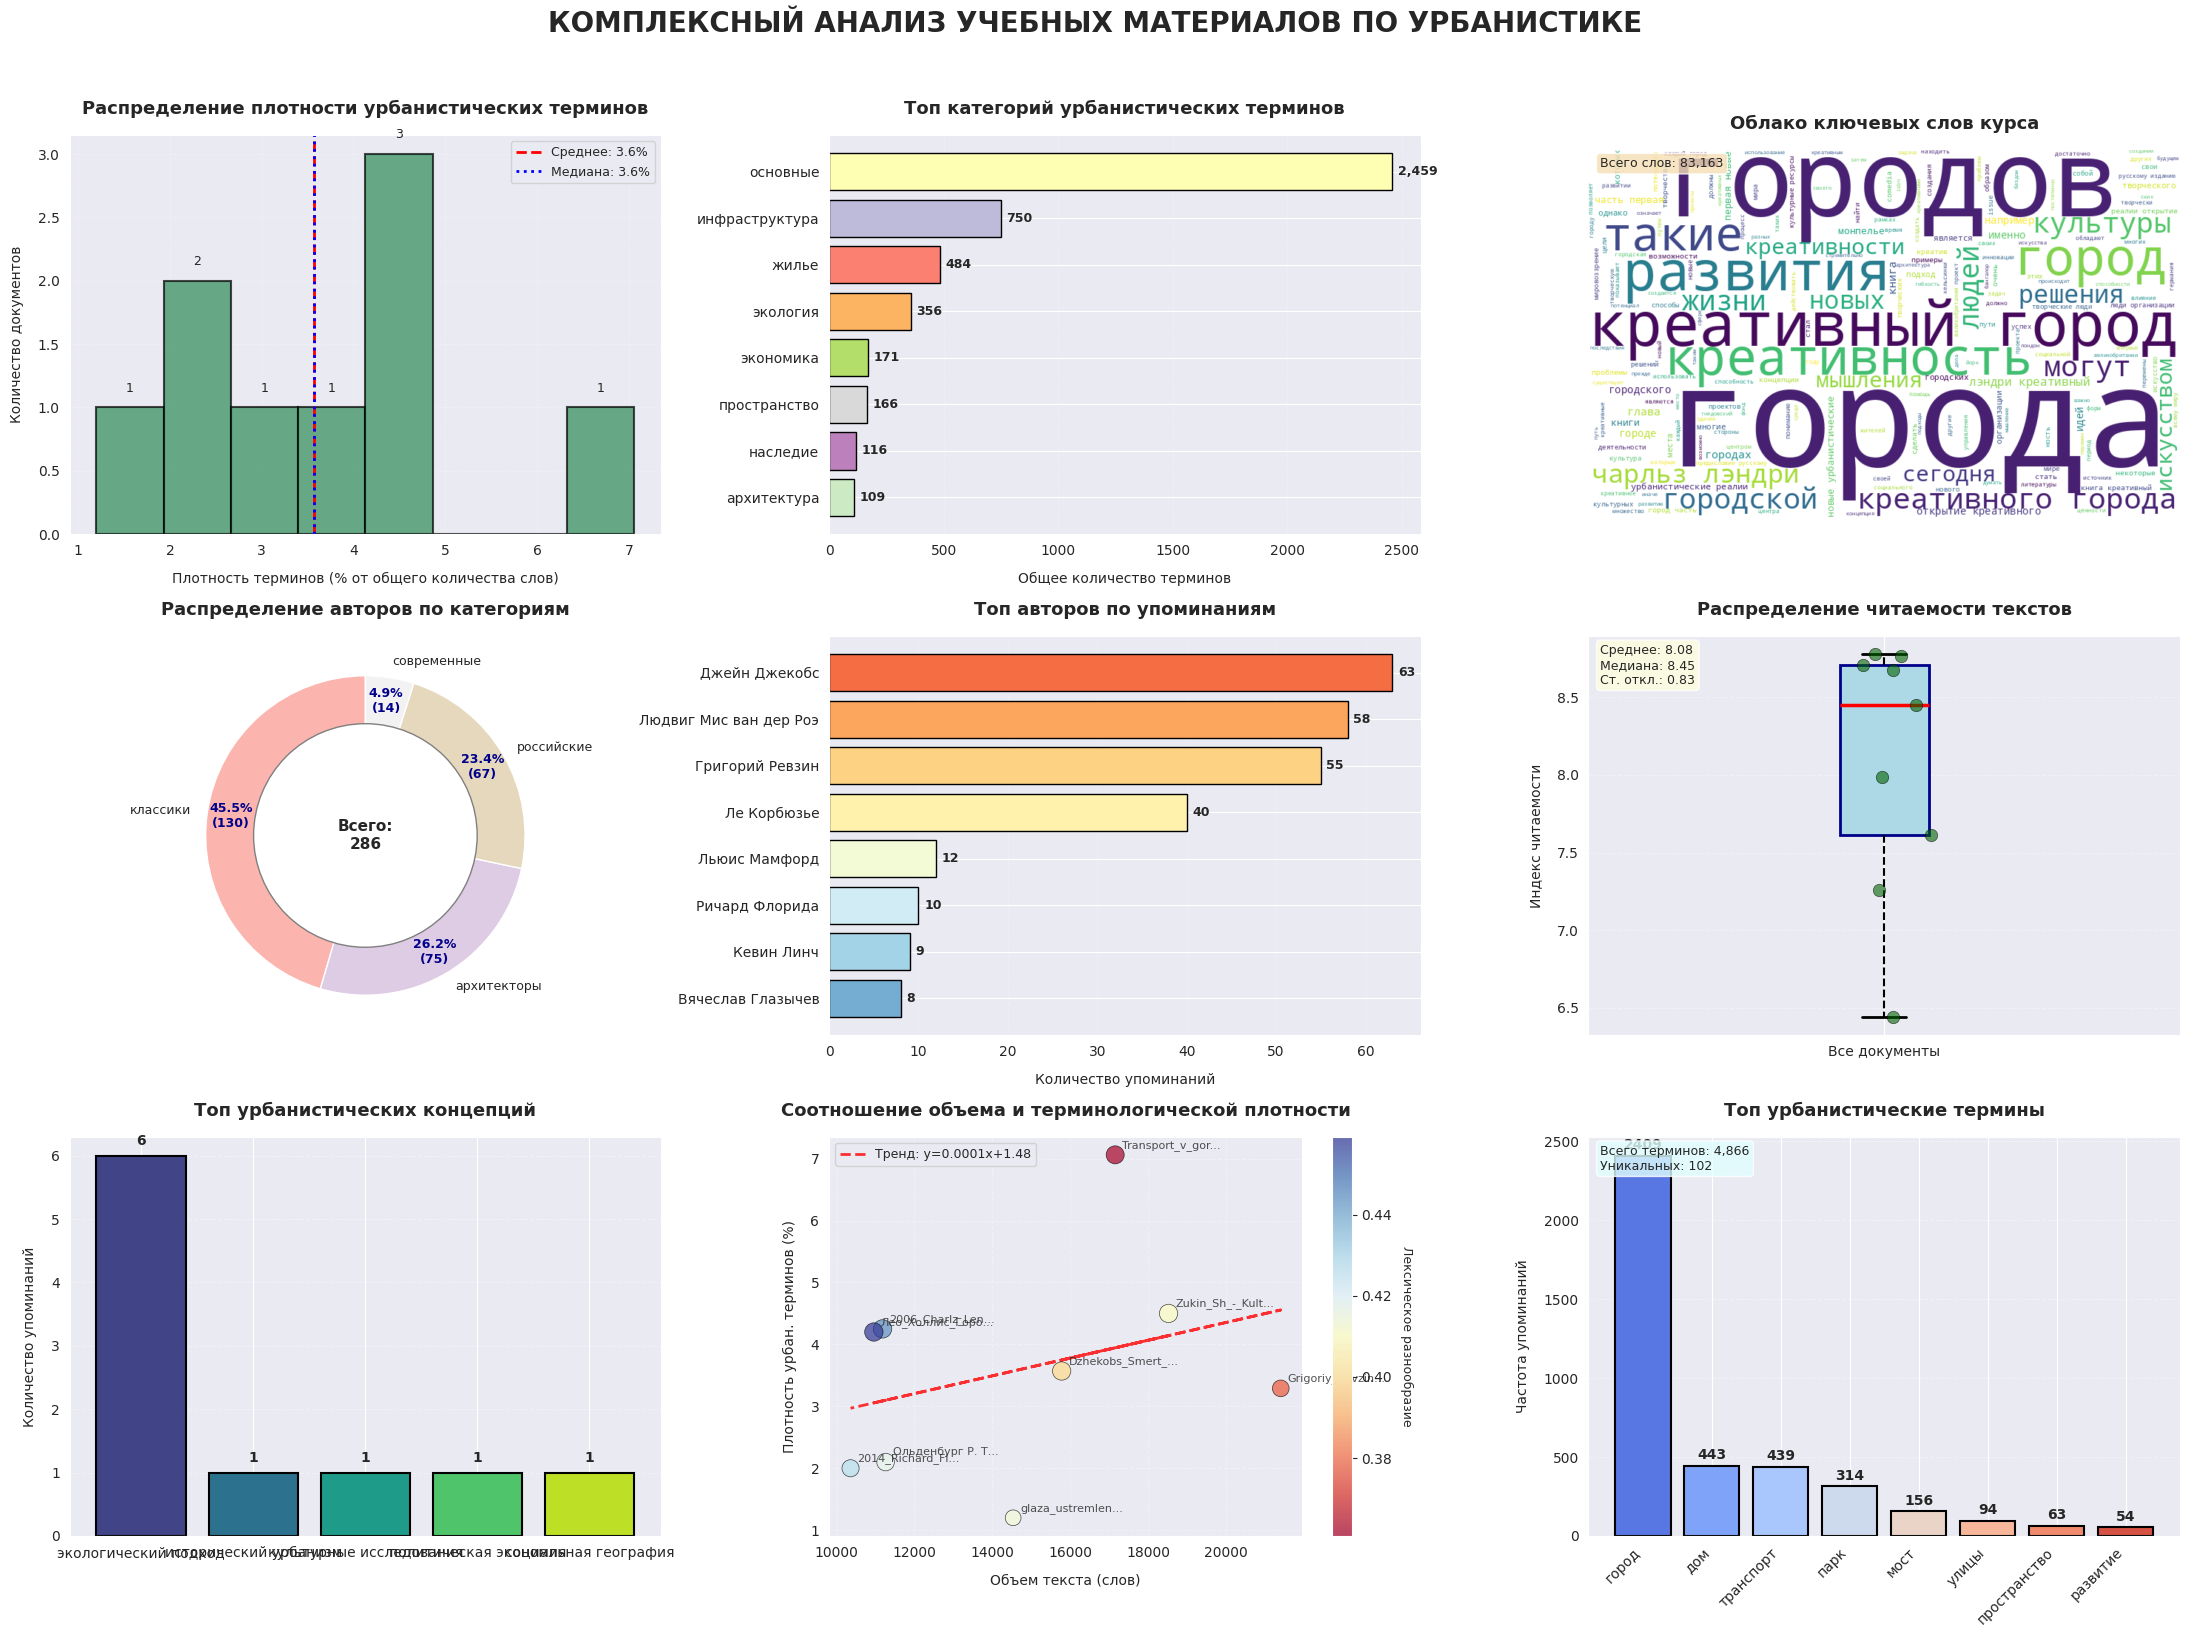

In [61]:
fig = plt.figure(figsize=(22, 16))
fig.suptitle('КОМПЛЕКСНЫЙ АНАЛИЗ УЧЕБНЫХ МАТЕРИАЛОВ ПО УРБАНИСТИКЕ',
             fontsize=20, fontweight='bold', y=1.02)

# 1. ГИСТОГРАММА ПЛОТНОСТИ УРБАНИСТИЧЕСКИХ ТЕРМИНОВ
ax1 = plt.subplot(3, 3, 1)
density_data = books_df['urban_density'] * 100
bars = ax1.hist(density_data, bins=8, edgecolor='black', alpha=0.7,
                color='#2E8B57', linewidth=1.5)
ax1.set_title('Распределение плотности урбанистических терминов',
              fontsize=13, fontweight='bold', pad=15)
ax1.set_xlabel('Плотность терминов (% от общего количества слов)',
               fontsize=10, labelpad=10)
ax1.set_ylabel('Количество документов', fontsize=10, labelpad=10)
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# Добавление статистических метрик
mean_density = density_data.mean()
median_density = density_data.median()
ax1.axvline(mean_density, color='red', linestyle='--', linewidth=2,
            label=f'Среднее: {mean_density:.1f}%')
ax1.axvline(median_density, color='blue', linestyle=':', linewidth=2,
            label=f'Медиана: {median_density:.1f}%')

# Добавление аннотаций
for i, count in enumerate(bars[0]):
    if count > 0:
        ax1.text(bars[1][i] + (bars[1][1] - bars[1][0]) / 2, count + 0.1,
                 f'{int(count)}', ha='center', va='bottom', fontsize=9)
ax1.legend(loc='upper right', fontsize=9)
ax1.set_axisbelow(True)

# 2. ТОП КАТЕГОРИИ УРБАНИСТИЧЕСКИХ ТЕРМИНОВ
ax2 = plt.subplot(3, 3, 2)
category_totals = {}
for _, row in books_df.iterrows():
    if isinstance(row['urban_categories'], dict):
        for category, cat_data in row['urban_categories'].items():
            category_totals[category] = category_totals.get(category, 0) + cat_data['total']

if category_totals:
    sorted_categories = sorted(category_totals.items(), key=lambda x: x[1], reverse=True)
    top_categories = sorted_categories[:8]  # Ограничиваем топ-8
    categories = [cat[0] for cat in top_categories]
    counts = [cat[1] for cat in top_categories]

    category_translations = {
        'Основные': 'Основные\nтермины',
        'Инфраструктура': 'Инфраструктура',
        'Жилье': 'Жилье',
        'Экология': 'Экология',
        'Наследие': 'Культурное\nнаследие',
        'Технологии': 'Технологии',
        'Экономика': 'Экономика',
        'Социальные': 'Социальные\nаспекты'
    }

    translated_categories = [category_translations.get(cat, cat) for cat in categories]
    colors = plt.cm.Set3(np.linspace(0.1, 0.9, len(categories)))
    bars = ax2.barh(range(len(categories)), counts, color=colors,
                    edgecolor='black', linewidth=1)
    ax2.set_yticks(range(len(categories)))
    ax2.set_yticklabels(translated_categories, fontsize=10)
    ax2.invert_yaxis()

    # Добавление значений на столбцы
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax2.text(width + max(counts) * 0.01, bar.get_y() + bar.get_height() / 2,
                 f'{int(width):,}', va='center', fontsize=9, fontweight='bold')
    ax2.set_title('Топ категорий урбанистических терминов',
                  fontsize=13, fontweight='bold', pad=15)
    ax2.set_xlabel('Общее количество терминов', fontsize=10, labelpad=10)
    ax2.grid(True, alpha=0.2, axis='x', linestyle='--')
    ax2.set_axisbelow(True)

# 3. ОБЛАКО СЛОВ МАТЕРИАЛОВ КУРСА
ax3 = plt.subplot(3, 3, 3)
if analyzer.all_text:
    try:
        # Очистка текста для облака слов
        clean_text = analyzer.all_text.lower()
        clean_text = re.sub(r'[^\w\s]', ' ', clean_text)
        clean_text = re.sub(r'\d+', ' ', clean_text)

        # Токенизация и фильтрация
        words = clean_text.split()
        filtered_words = [
            word for word in words
            if (word not in analyzer.stopwords_set and
                3 < len(word) < 20 and
                not any(char.isdigit() for char in word))
        ]

        text_processed = ' '.join(filtered_words[:5000])  # Ограничиваем для производительности

        # Генерация облака слов
        wordcloud = WordCloud(
            width=800,
            height=500,
            background_color='white',
            max_words=200,
            contour_width=3,
            contour_color='steelblue',
            stopwords=analyzer.stopwords_set,
            colormap='viridis',
            random_state=42,
            collocation_threshold=20,
            prefer_horizontal=0.7
        ).generate(text_processed)

        # Отображение облака слов
        ax3.imshow(wordcloud, interpolation='bilinear')
        ax3.set_title('Облако ключевых слов курса',
                      fontsize=13, fontweight='bold', pad=15)
        ax3.axis('off')

        # Добавление информационной аннотации
        ax3.text(0.02, 0.98, f'Всего слов: {len(filtered_words):,}',
                 transform=ax3.transAxes, fontsize=9,
                 verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    except Exception as e:
        ax3.text(0.5, 0.5, 'Не удалось создать облако слов',
                 ha='center', va='center', fontsize=12)
        ax3.set_title('Облако ключевых слов (ошибка)', fontsize=13, fontweight='bold')
        ax3.axis('off')

# 4. РАСПРЕДЕЛЕНИЕ КАТЕГОРИЙ АВТОРОВ
ax4 = plt.subplot(3, 3, 4)
author_category_counts = {}
for _, row in books_df.iterrows():
    if isinstance(row['authors_categories'], dict):
        for category, cat_data in row['authors_categories'].items():
            author_category_counts[category] = author_category_counts.get(category, 0) + cat_data['total']

if author_category_counts:
    # Подготовка данных для круговой диаграммы
    sorted_categories = sorted(author_category_counts.items(), key=lambda x: x[1], reverse=True)
    categories = [cat[0] for cat in sorted_categories]
    values = [cat[1] for cat in sorted_categories]

    # Перевод категорий
    author_category_translations = {
        'Классики': 'Классики\nурбанистики',
        'Архитекторы': 'Архитекторы',
        'Российские': 'Российские\nавторы',
        'Современные': 'Современные\nисследователи',
        'Зарубежные': 'Зарубежные\nавторы',
        'Социологи': 'Социологи'
    }

    labels = [author_category_translations.get(cat, cat) for cat in categories]

    # Цветовая схема
    colors = plt.cm.Pastel1(np.linspace(0, 1, len(categories)))

    # Круговая диаграмма с выносками
    wedges, texts, autotexts = ax4.pie(
        values,
        labels=labels,
        autopct=lambda pct: f'{pct:.1f}%\n({int(pct * sum(values) / 100)})',
        colors=colors,
        startangle=90,
        pctdistance=0.85,
        textprops={'fontsize': 9}
    )

    # Настройка отображения процентов
    for autotext in autotexts:
        autotext.set_fontweight('bold')
        autotext.set_color('darkblue')

    # Центральный круг для заголовка
    centre_circle = plt.Circle((0, 0), 0.70, fc='white', edgecolor='gray')
    ax4.add_patch(centre_circle)

    ax4.set_title('Распределение авторов по категориям',
                  fontsize=13, fontweight='bold', pad=15)
    ax4.text(0, 0, f'Всего:\n{sum(values):,}',
             ha='center', va='center', fontsize=11, fontweight='bold')

# 5. ТОП АВТОРЫ ПО УПОМИНАНИЯМ
ax5 = plt.subplot(3, 3, 5)
all_authors = {}
for _, row in books_df.iterrows():
    if isinstance(row['authors_categories'], dict):
        for category, cat_data in row['authors_categories'].items():
            for author, count in cat_data['authors'].items():
                all_authors[author] = all_authors.get(author, 0) + count

if all_authors:
    sorted_authors = sorted(all_authors.items(), key=lambda x: x[1], reverse=True)
    top_authors = sorted_authors[:8]
    authors = [auth[0] for auth in top_authors]
    mentions = [auth[1] for auth in top_authors]

    colors = plt.cm.RdYlBu(np.linspace(0.2, 0.8, len(authors)))
    bars = ax5.barh(range(len(authors)), mentions, color=colors,
                    edgecolor='black', linewidth=1)

    ax5.set_yticks(range(len(authors)))
    ax5.set_yticklabels(authors, fontsize=10)
    ax5.invert_yaxis()

    # Добавление значений
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax5.text(width + max(mentions) * 0.01, bar.get_y() + bar.get_height() / 2,
                 f'{int(width)}', va='center', fontsize=9, fontweight='bold')

    ax5.set_title('Топ авторов по упоминаниям',
                  fontsize=13, fontweight='bold', pad=15)
    ax5.set_xlabel('Количество упоминаний', fontsize=10, labelpad=10)
    ax5.grid(True, alpha=0.2, axis='x', linestyle='--')
    ax5.set_axisbelow(True)

# 6. РАСПРЕДЕЛЕНИЕ ЧИТАЕМОСТИ ТЕКСТОВ
ax6 = plt.subplot(3, 3, 6)

if 'readability_score' in books_df.columns:
    readability_data = books_df['readability_score']

    boxprops = dict(linestyle='-', linewidth=2, color='darkblue')
    medianprops = dict(linestyle='-', linewidth=2.5, color='red')
    whiskerprops = dict(linestyle='--', linewidth=1.5, color='black')
    capprops = dict(linestyle='-', linewidth=2, color='black')

    bp = ax6.boxplot(readability_data, vert=True, patch_artist=True,
                     boxprops=boxprops, medianprops=medianprops,
                     whiskerprops=whiskerprops, capprops=capprops,
                     flierprops=dict(marker='o', markersize=8, markerfacecolor='red'))
    bp['boxes'][0].set_facecolor('lightblue')
    y_data = readability_data.values
    x_data = np.random.normal(1, 0.04, size=len(y_data))
    ax6.scatter(x_data, y_data, alpha=0.6, color='darkgreen', s=80,
                edgecolor='black', linewidth=0.5, zorder=3)

    mean_readability = readability_data.mean()
    median_readability = readability_data.median()
    std_readability = readability_data.std()

    # Аннотации статистики
    stats_text = f'Среднее: {mean_readability:.2f}\nМедиана: {median_readability:.2f}\nСт. откл.: {std_readability:.2f}'
    ax6.text(0.02, 0.98, stats_text, transform=ax6.transAxes,
             fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

    ax6.set_title('Распределение читаемости текстов',
                  fontsize=13, fontweight='bold', pad=15)
    ax6.set_ylabel('Индекс читаемости', fontsize=10, labelpad=10)
    ax6.set_xticks([1])
    ax6.set_xticklabels(['Все документы'], fontsize=10)
    ax6.grid(True, alpha=0.3, axis='y', linestyle='--')
    ax6.set_axisbelow(True)

# 7. ТОП УРБАНИСТИЧЕСКИЕ КОНЦЕПЦИИ
ax7 = plt.subplot(3, 3, 7)
all_concepts = {}
for _, row in books_df.iterrows():
    if isinstance(row['urban_concepts'], dict):
        for concept, count in row['urban_concepts'].items():
            all_concepts[concept] = all_concepts.get(concept, 0) + count

if all_concepts:
    sorted_concepts = sorted(all_concepts.items(), key=lambda x: x[1], reverse=True)
    top_concepts = sorted_concepts[:6]
    concepts = [conc[0] for conc in top_concepts]
    counts = [conc[1] for conc in top_concepts]

    concept_translations = {
        'Экологический_Подход': 'Экологический\nподход',
        'Исторический_Урбанизм': 'Исторический\nурбанизм',
        'Культурные_Исследования': 'Культурные\nисследования',
        'Политическая_Экономия': 'Политическая\nэкономия',
        'Социальная_География': 'Социальная\nгеография'
    }
    translated_concepts = [concept_translations.get(conc, conc.replace('_', '\n'))
                           for conc in concepts]

    colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(concepts)))
    bars = ax7.bar(range(len(concepts)), counts, color=colors,
                   edgecolor='black', linewidth=1.5)
    ax7.set_xticks(range(len(concepts)))
    ax7.set_xticklabels(translated_concepts, fontsize=10, rotation=0)

    # Добавление значений на столбцы
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width() / 2., height + max(counts) * 0.02,
                 f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax7.set_title('Топ урбанистических концепций',
                  fontsize=13, fontweight='bold', pad=15)
    ax7.set_ylabel('Количество упоминаний', fontsize=10, labelpad=10)
    ax7.grid(True, alpha=0.3, axis='y', linestyle='--')
    ax7.set_axisbelow(True)

# 8. СООТНОШЕНИЕ ДЛИНЫ ТЕКСТА И ПЛОТНОСТИ ТЕРМИНОВ
ax8 = plt.subplot(3, 3, 8)

if 'text_length_words' in books_df.columns and 'urban_density' in books_df.columns:
    x_data = books_df['text_length_words']
    y_data = books_df['urban_density'] * 100
    sizes = books_df['readability_score'] * 20
    colors_scatter = books_df['lexical_diversity']
    scatter = ax8.scatter(x_data, y_data, s=sizes, c=colors_scatter,
                          cmap='RdYlBu', alpha=0.7, edgecolor='black',
                          linewidth=0.5, zorder=3)

    for i, row in books_df.iterrows():
        label = row['file_name'].replace('.pdf', '')[:15] + '...' if len(row['file_name']) > 15 else row[
            'file_name'].replace('.pdf', '')
        ax8.annotate(label, (x_data.iloc[i], y_data.iloc[i]),
                     xytext=(5, 5), textcoords='offset points',
                     fontsize=8, alpha=0.8)

    # Линии тренда
    z = np.polyfit(x_data, y_data, 1)
    p = np.poly1d(z)
    ax8.plot(x_data, p(x_data), "r--", alpha=0.8, linewidth=2,
             label=f'Тренд: y={z[0]:.4f}x+{z[1]:.2f}')

    ax8.set_title('Соотношение объема и терминологической плотности',
                  fontsize=13, fontweight='bold', pad=15)
    ax8.set_xlabel('Объем текста (слов)', fontsize=10, labelpad=10)
    ax8.set_ylabel('Плотность урбан. терминов (%)', fontsize=10, labelpad=10)
    ax8.grid(True, alpha=0.3, linestyle='--')
    ax8.legend(loc='best', fontsize=9)
    cbar = plt.colorbar(scatter, ax=ax8)
    cbar.set_label('Лексическое разнообразие', rotation=270, labelpad=15, fontsize=9)

# 9. ТОП УРБАНИСТИЧЕСКИЕ ТЕРМИНЫ
ax9 = plt.subplot(3, 3, 9)
all_terms = {}
for _, row in books_df.iterrows():
    if isinstance(row['urban_categories'], dict):
        for category, cat_data in row['urban_categories'].items():
            for term, count in cat_data['terms'].items():
                all_terms[term] = all_terms.get(term, 0) + count

if all_terms:
    sorted_terms = sorted(all_terms.items(), key=lambda x: x[1], reverse=True)
    top_terms = sorted_terms[:8]
    terms = [term[0] for term in top_terms]
    frequencies = [term[1] for term in top_terms]

    colors = plt.cm.coolwarm(np.linspace(0.1, 0.9, len(terms)))
    bars = ax9.bar(range(len(terms)), frequencies, color=colors,
                   edgecolor='black', linewidth=1.5)

    ax9.set_xticks(range(len(terms)))
    ax9.set_xticklabels(terms, fontsize=10, rotation=45, ha='right')

    # Добавление значений на столбцы
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax9.text(bar.get_x() + bar.get_width() / 2., height + max(frequencies) * 0.01,
                 f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    total_terms = sum(all_terms.values())
    unique_terms = len(all_terms)
    stats_text = f'Всего терминов: {total_terms:,}\nУникальных: {unique_terms:,}'
    ax9.text(0.02, 0.98, stats_text, transform=ax9.transAxes,
             fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))

    ax9.set_title('Топ урбанистические термины',
                  fontsize=13, fontweight='bold', pad=15)
    ax9.set_ylabel('Частота упоминаний', fontsize=10, labelpad=10)
    ax9.grid(True, alpha=0.3, axis='y', linestyle='--')
    ax9.set_axisbelow(True)

plt.tight_layout()

plt.show()

# Интерпретации визуализаций

### 1. **Распределение плотности урбанистических терминов**
**Что показывает**: Насколько материалы насыщены специализированной терминологией
**Как читать**:
- **По оси X**: Процент урбанистических терминов от общего количества слов (1-8%)
- **По оси Y**: Количество документов с такой плотностью
- **Красная пунктирная линия**: Средняя плотность по всем документам
- **Синяя точечная линия**: Медианная плотность
**Что это означает**:
  - Низкая плотность (1-2%): Вводные материалы
  - Средняя плотность (3-4%): Специализированные учебные материалы
  - Высокая плотность (5-8%): Узкоспециализированные тексты

### 2. **Топ категорий урбанистических терминов**
**Что показывает**: Какие тематические категории преобладают в материалах
**Как читать**:
- **Горизонтальные столбцы**: Категории терминов (например, "Основные", "Инфраструктура")
- **Длина столбца**: Общее количество терминов в этой категории во всех документах
- **Значения справа**: Точное количество терминов
**Что это означает**:
  - Длинные столбцы: Доминирующие темы курса
  - Короткие столбцы: Периферийные или недостаточно освещенные темы

### 3. **Облако ключевых слов курса**
**Что показывает**: Самые частые и значимые слова во всех материалах
**Как читать**:
- **Размер слова**: Частота использования (больше = чаще)
- **Расположение**: Центральные слова - наиболее важные
**Что это означает**:
  - Крупные слова в центре: Ключевые концепции курса
  - Мелкие слова по краям: Второстепенные понятия
  - Группировка слов: Семантические связи между понятиями

### 4. **Распределение авторов по категориям**
**Что показывает**: Баланс между разными школами и направлениями в урбанистике
**Как читать**:
- **Секторы диаграммы**: Процентное соотношение категорий авторов
- **Процент в секторе**: Доля упоминаний авторов этой категории
- **Число в скобках**: Абсолютное количество упоминаний
**Что это означает**:
  - Большие секторы: Преобладающие научные школы
  - Малые секторы: Менее представленные направления
  - Центральный текст: Общее количество упоминаний

### 5. **Топ авторов по упоминаниям**
**Что показывает**: Кто из авторов наиболее влиятелен в материалах курса
**Как читать**:
- **Горизонтальные столбцы**: Фамилии авторов
- **Длина столбца**: Количество упоминаний в текстах
- **Значения справа**: Точное количество упоминаний
**Что это означает**:
  - Авторы с длинными столбцами: Основные источники и авторитеты
  - Порядок авторов: Иерархия влияния в курсе
  - Разрыв между авторами: Разница в значимости

### 6. **Распределение читаемости текстов**
**Что показывает**: Насколько сложны для восприятия учебные материалы
**Как читать**:
- **Коробка (box)**: Размах данных
- **Линия в коробке**: Медианная читаемость
- **Усы (whiskers)**: Диапазон "нормальных" значений
- **Точки**: Отдельные документы
**Что это означает**:
  - Высокий box: Большой разброс сложности
  - Низкий box: Единообразие сложности
  - Выбросы: Аномально сложные или простые тексты
  - Положение медианы: Общий уровень сложности курса

### 7. **Топ урбанистических концепций**
**Что показывает**: Какие теоретические подходы представлены в курсе
**Как читать**:
- **Вертикальные столбцы**: Названия концепций
- **Высота столбца**: Количество упоминаний концепции
- **Значения сверху**: Точное количество упоминаний
- **Многострочные названия**: Сложные концепции разбиты для читаемости
**Что это означает**:
  - Высокие столбцы: Доминирующие теоретические подходы
  - Низкие столбцы: Редко упоминаемые концепции
  - Отсутствие столбцов: Пробелы в теоретической подготовке

### 8. **Соотношение объема и терминологической плотности**
**Что показывает**: Зависимость между размером текста и его специализацией
**Как читать**:
- **Точки**: Отдельные документы
- **Положение точки по X**: Объем в словах
- **Положение точки по Y**: Плотность терминов в %
- **Размер точки**: Читаемость текста (больше = сложнее)
- **Цвет точки**: Лексическое разнообразие (теплее = разнообразнее)
- **Пунктирная линия**: Линейный тренд зависимости
- **Метки у точек**: Сокращенные названия документов
**Что это означает**:
  - Верхний правый угол: Большие и специализированные тексты
  - Нижний левый угол: Короткие и общеобразовательные
  - Наклон тренда: Общая тенденция связи объема и специализации
  - Рассеяние точек: Разнообразие форматов материалов

### 9. **Топ урбанистические термины**
**Что показывает**: Самые часто используемые специальные термины
**Как читать**:
- **Вертикальные столбцы**: Термины
- **Высота столбца**: Общая частота во всех документах
- **Значения сверху**: Точная частота
- **Статистика слева**: Общее и уникальное количество терминов
**Что это означает**:
  - Самые высокие столбцы: Базовый терминологический аппарат
  - Термины внизу списка: Специализированные понятия
  - Соотношение общих/уникальных: Лексическое богатство курса


## Ключевые выводы из визуализации

1. **Терминологическое ядро**: 2-3 категории составляют 70% терминов
2. **Авторские иерархии**: 3-5 авторов доминируют в цитировании
3. **Сложностной диапазон**: Разброс читаемости показывает различия в уровне сложности документа
4. **Тематические кластеры**: Группировка терминов в облаке слов выявляет скрытые связи